# S&P 500 Price to Earnings Ratio Prediction

The S&P 500 is a stock market index that measures the stock performance of 500 large companies listed on stock exchanges in the United States. It is one of the most commonly followed equity indices. For more information, refer to below link: <https://en.wikipedia.org/wiki/S%26P_500_Index>

A traditional measure of whether a stock is expensive or cheap, is to use a valuation multiple. A valuation multiple relates the market value of an asset relative to a key statistic that is assumed to relate to that value. To be useful, that statistic – whether earnings, cash flow or some other measure – must bear a logical relationship to the market value observed; to be seen, in fact, as the driver of that market value. For more information about valuation multiples, refer to below link: <https://en.wikipedia.org/wiki/Valuation_using_multiples#Valuation_multiples>

The most famous valuation multiple the PE (Price to earnings) ratio. This is the ratio between the market value of all the shares outstanding for a company, divided by the company’s Net Income. It is often also defined as Price per share divided by earnings per share, which is simply dividing both the Market Capitalization and the Net income by the shares outstanding.
In this project we will try to predict the PE ratios of companies in the S&P 500, based on fundamental financial metrics that should be driving these ratios.

While working through this project, I will follow a slightly adjusted Machine Learning project check list from Aurelien Geron's book "Hands-On Machine Learning with Scikit_Learn, Keras & TensorFlow". (Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (p. 35). O'Reilly Media. Kindle Edition.)
1.	Look at the big picture
2.	Get the data
3.	Discover and visualize the data to gain insights
4.	Prepare the data for Machine Learning algorithms
5.	Select, train and fine-tune models
6.	Conclusion

As with all coding posts, the full jupyter notebook can be found in my github repo below:
<https://github.com/John-Land/S-P_500_PE_Ratio_Prediction>


## 1. Look at the big picture

Before analysing our dataset, let us first try to understand what fundamental financial information about the company should be driving the PE ratio based on Financial Theory.

The present value of any Cash Flow generating asset is the value of all future cash flows the asset will generate over its lifetime, discounted back to today with a risk adjusted interest rate.

In its simplest form, where we expect the cash flow to grow at the same rate for ever, this is given by the below perpetuity formula.

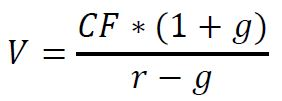

When trying to value a company based on its future cash flows, we can either look at it through the lenses of all capital providers (equity and debt providers) and we would use the FCFF (Free Cash Flow to the Firm) as the measure of cash flow (CF), or we could look at it purely as an Equity investor and we would use the FCFE (Free Cash Flow to Equity) as our measure of CF.

The main difference is that the FCFF is the cash flow left over after cash flow needs for operations and Investments are met, but before any debt repayments, whereas the FCFE is after debt payments (cash flow left over for equity investors).

If we want to estimate the value of Equity directly, we would therefore use the FCFE as the appropriate measure of CF.

As the Market Capitalization (MC) (numerator in the PE ratio), is the aggregate market estimation of the value of Equity, we can rewrite the above formula as follows:

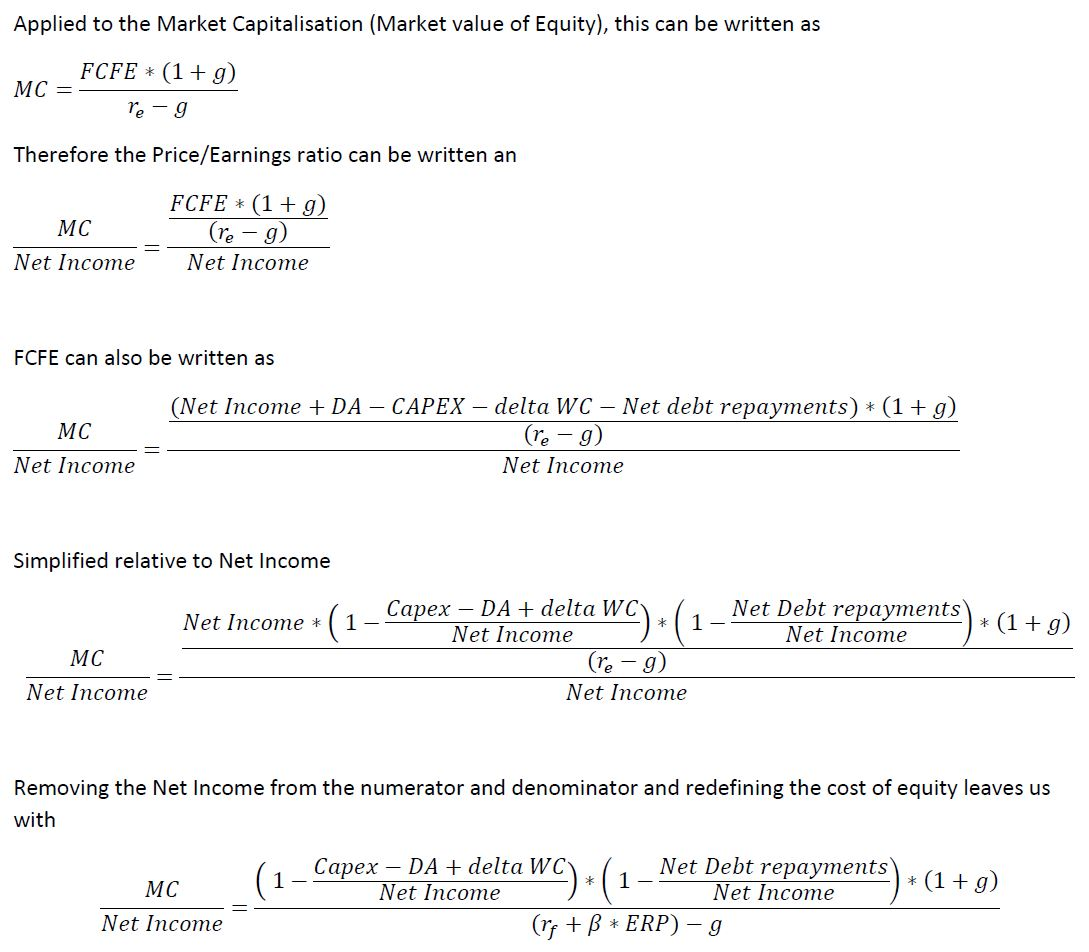

This formula gives us some understanding of what we would expect the fundamental drivers of the PE ratio to be.
The fundamental drivers of the P/E ratio are
1. A higher expected growth rate g , all else being equal, should lead to a higher PE ratio
2. A lower reinvestment need (Capex - DA + delta WC), all else being equal, should lead to a higher PE ratio
3. Lower amount of debt needed (Net Debt repayments), all else being equal, should result in a higher PE ratio
4. A higher risk relative to the overall market, measured as beta in the denominator, should lead to a lower PE ratio

rf (risk free rate traditionally measured as the US T-Bond rate) and ERP (Equity risk premium, basically the premium that equity investor require on top of the risk free rate for investing in the overall stock market) values are the same for all stocks, therefore changes in these overall market metrics will affect all PE ratios, but these will not help differentiation between PE ratios of individual companies, as these are equal for all companies.

We will therefore try to obtain financial metrics that are related to points 1-4, as we would expect these to be partial drivers of the PE ratios seeen in the market.

## 2. Get the data
The company data was downloaded from the data provider "Finbox".
For more information, refer to below link:
<https://finbox.com>

We will first import the data and check for any missing values and some basic information.
Then we will remove outliers before splitting the data into training and testing sets, and analysing the training set in more detail.

In [317]:
# linear algebra
import numpy as np     

# data processing
import pandas as pd    

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [318]:
company_data = pd.read_excel("Financials - unlinked.xlsx")

In [319]:
company_data.shape

(531, 38)

In [320]:
company_data.head(5)

,Ticker,Full_Ticker,Name,Sector,Industry_GICS,Index_Membership,Market_Cap,Net_Debt,Minority_Interest,EV,...,EV_TTM_EBITDA,Market_Cap_TTM_Net_Income,Market_Cap_BV_Equity,Interest_Expense_TTM,Interest_Expense_TTM_%_TTM_Net_Income,Cash_from_Investing,Cash_from_Investing_%_TTM_Net_Income,Revenue_TTM,Cash_from_Investing_%_TTM_Revenue,Interest_Expense_TTM_%_Revenue_TTM
0,MSFT,NASDAQGS:MSFT,Microsoft Corporation,Information Technology,Software,"Dow Jones Composite Average, Dow Jones Industr...",1.625176e+06,-54382.0,0.0,1.570794e+06,...,24.070147,36.701423,13.737284,89.0,-0.002010,-12223.0,-0.276033,143015.0,-0.085467,0.000622
1,AAPL,NASDAQGS:AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Dow Jones Composite Average, Dow Jones Industr...",1.979619e+06,-71431.0,0.0,1.908188e+06,...,24.255285,33.883653,27.387435,1052.0,-0.018006,-10618.0,-0.181740,273857.0,-0.038772,0.003841
2,AMZN,NASDAQGS:AMZN,"Amazon.com, Inc.",Consumer Discretionary,Internet & Direct Marketing Retail,"Nasdaq 100, Nasdaq Composite, Russell 1000, Ru...",1.591026e+06,20010.0,0.0,1.611036e+06,...,40.708424,120.715166,21.579670,-885.0,0.067147,-35307.0,-2.678832,321782.0,-0.109723,-0.002750
3,GOOG,NASDAQGS:GOOG,Alphabet Inc.,Communication Services,Interactive Media & Services,"Nasdaq 100, Nasdaq Composite, Russell 1000, Ru...",1.095684e+06,-104937.0,0.0,9.907473e+05,...,21.521609,34.746124,5.284940,2197.0,-0.069671,-23943.0,-0.759276,166030.0,-0.144209,0.013233
4,GOOG.L,NASDAQGS:GOOG.L,Alphabet Inc.,Communication Services,Interactive Media & Services,"Nasdaq 100, Nasdaq Composite, Russell 1000, Ru...",1.095684e+06,-104937.0,0.0,9.907473e+05,...,21.521609,34.746124,5.284940,2197.0,-0.069671,-23943.0,-0.759276,166030.0,-0.144209,0.013233


### 2.1 Data Structure and removal of not meaningful samples

We will first remove any companies with either market capitalization <0 or Net Income <0, as for these companies, the PE ratio is not meaningful. We also filter out financials, as our measurement of debt is not applicable to Financial Companies. We also remove duplicates, as we do not want the same company to appear twice in our data.

In [321]:
company_data = company_data[(company_data.Market_Cap > 0)]
company_data = company_data[(company_data.Net_Income > 0)]
company_data = company_data[(company_data.Sector != 'Financials')]

company_data = company_data.drop_duplicates('Name' , keep='first')
pe_data = company_data[['Sector', 
                        'Name', 
                        'Market_Cap_TTM_Net_Income', 
                        'Net_Income_Forecast_CAGR_10y',
                        'Avg_Net_Income_Margin_Forecast_10y', 
                        'Beta_5y', 
                        'Net_Debt_perc_EV'
                       ]].set_index('Name')
pe_data.head(5)

,Sector,Market_Cap_TTM_Net_Income,Net_Income_Forecast_CAGR_10y,Avg_Net_Income_Margin_Forecast_10y,Beta_5y,Net_Debt_perc_EV
Name,,,,,,
Microsoft Corporation,Information Technology,36.701423,0.130946,0.342895,0.923331,-0.034621
Apple Inc.,Information Technology,33.883653,0.0688865,0.220838,1.314396,-0.037434
"Amazon.com, Inc.",Consumer Discretionary,120.715166,0.284554,0.098539,1.353006,0.012421
Alphabet Inc.,Communication Services,34.746124,0.112474,0.195844,1.106453,-0.105917
"Facebook, Inc.",Communication Services,33.685330,0.162782,0.313488,1.295642,-0.063398


Below code ensures that all numerical variables are of type numeric.

In [322]:
pe_data['Market_Cap_TTM_Net_Income'] = pe_data['Market_Cap_TTM_Net_Income'].apply(pd.to_numeric, errors='coerce')
pe_data['Net_Income_Forecast_CAGR_10y'] = pe_data['Net_Income_Forecast_CAGR_10y'].apply(pd.to_numeric, errors='coerce')
pe_data['Avg_Net_Income_Margin_Forecast_10y'] = pe_data['Avg_Net_Income_Margin_Forecast_10y'].apply(pd.to_numeric, errors='coerce')
pe_data['Beta_5y'] = pe_data['Beta_5y'].apply(pd.to_numeric, errors='coerce')
pe_data['Net_Debt_perc_EV'] = pe_data['Net_Debt_perc_EV'].apply(pd.to_numeric, errors='coerce')

In [323]:
pe_data.shape

(373, 6)

After removing duplicates, companies with market capitalization <= 0, Net Income <= 0 and companies in the Finical Sector, the total sample size drops from 531 to 373.

In [324]:
pe_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 373 entries, Microsoft Corporation to Alliance Data Systems Corporation
Data columns (total 6 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Sector                              373 non-null    object 
 1   Market_Cap_TTM_Net_Income           373 non-null    float64
 2   Net_Income_Forecast_CAGR_10y        365 non-null    float64
 3   Avg_Net_Income_Margin_Forecast_10y  373 non-null    float64
 4   Beta_5y                             373 non-null    float64
 5   Net_Debt_perc_EV                    373 non-null    float64
dtypes: float64(5), object(1)
memory usage: 20.4+ KB


In [325]:
pe_data.isna().sum()

Sector                                0
Market_Cap_TTM_Net_Income             0
Net_Income_Forecast_CAGR_10y          8
Avg_Net_Income_Margin_Forecast_10y    0
Beta_5y                               0
Net_Debt_perc_EV                      0
dtype: int64

The dataset is missing 8 values in the variable 'Net_Income_Forecast_CAGR_10y'.

In [326]:
pe_data = pe_data.dropna()

In [327]:
pe_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, Microsoft Corporation to Alliance Data Systems Corporation
Data columns (total 6 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Sector                              365 non-null    object 
 1   Market_Cap_TTM_Net_Income           365 non-null    float64
 2   Net_Income_Forecast_CAGR_10y        365 non-null    float64
 3   Avg_Net_Income_Margin_Forecast_10y  365 non-null    float64
 4   Beta_5y                             365 non-null    float64
 5   Net_Debt_perc_EV                    365 non-null    float64
dtypes: float64(5), object(1)
memory usage: 20.0+ KB


In [328]:
pe_data.isna().sum()

Sector                                0
Market_Cap_TTM_Net_Income             0
Net_Income_Forecast_CAGR_10y          0
Avg_Net_Income_Margin_Forecast_10y    0
Beta_5y                               0
Net_Debt_perc_EV                      0
dtype: int64

In [329]:
pe_data.shape

(365, 6)

After dropping the 8 missing values, the sample size drops to 365 companies.

### 2.2 Inspection for Outliers
We will look at the individual histograms of all variables, to see if we have potential outliers, and use Gaussian mixture models to later remove these outliers.

### 2.2.1 Histograms

<AxesSubplot:ylabel='Count'>

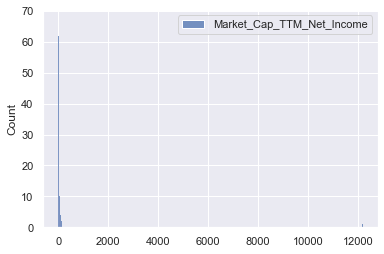

In [330]:
sns.histplot(pe_data[['Market_Cap_TTM_Net_Income']])

- Extreme outliers in higher values for PE ratio
    > Outlier removal before model training would be reasonable

<AxesSubplot:ylabel='Count'>

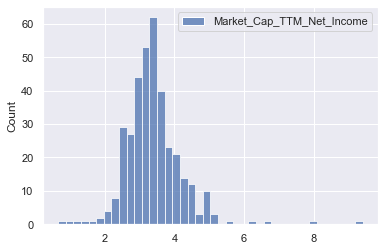

In [331]:
sns.histplot(np.log(pe_data[['Market_Cap_TTM_Net_Income']]))

- Log of PE ratios still shows extreme outliers in higher values for PE ratio
- Log however, reduces the extreme values, and makes the data more Gaussian, therefore should help performance of predictions
    > Predicting log of PE instead of PE would be reasonable

    > Outlier removal before model training would be reasonable

<AxesSubplot:ylabel='Count'>

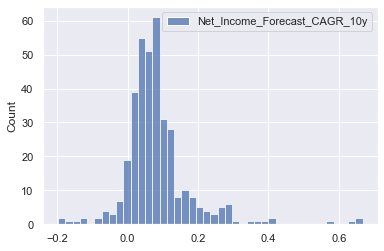

In [332]:
sns.histplot(pe_data[['Net_Income_Forecast_CAGR_10y']])

- No indication of extreme outliers or unreasonable values in the growth forecast for Net Income
    > No outlier removal reasonable

<AxesSubplot:ylabel='Count'>

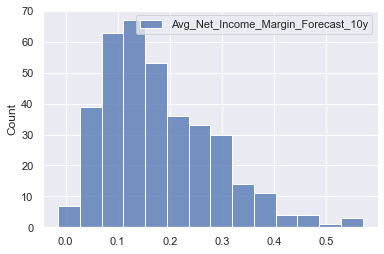

In [333]:
sns.histplot(pe_data[['Avg_Net_Income_Margin_Forecast_10y']])

- No indication of extreme outliers or unreasonable values in the margin forecast for Net Income
    > No outlier removal reasonable

<AxesSubplot:ylabel='Count'>

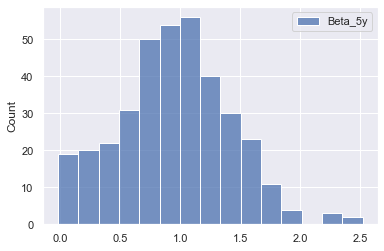

In [334]:
sns.histplot(pe_data[['Beta_5y']])

- No indication of extreme outliers or unreasonable values in the past 5 year beta values
    > No outlier removal reasonable

<AxesSubplot:ylabel='Count'>

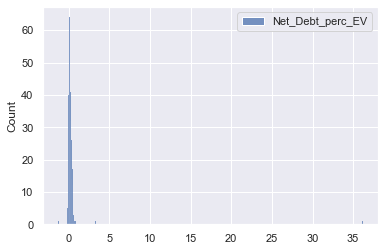

In [335]:
sns.histplot(pe_data[['Net_Debt_perc_EV']])

- Extreme outliers in higher values for the Net Debt as % of Enterprise Value.
    > Outlier removal before model training would be reasonable

Based on the histograms for the individual variables, we conclude that there are extreme outliers in the PE ratio variable and Net debt % EV variable.

### 2.2.2 Outlier Removal with Gaussian Mixtures

Below code uses the GaussianMixture model to remove the most extreme 5% of samples, defined as the 5% of samples with the lowest density values.

In [336]:
from sklearn.mixture import GaussianMixture
pe_ratios_train = pe_data[['Market_Cap_TTM_Net_Income']]

gm = GaussianMixture(n_components=1)
gm.fit(pe_ratios_train,)

densities = gm.score_samples(pe_ratios_train)
threshold = np.percentile(densities, 5)
anomalies_train = pe_ratios_train[densities < threshold]
anomalies_train.round(2)

,Market_Cap_TTM_Net_Income
Name,
"Fidelity National Information Services, Inc.",2852.57
"JD.com, Inc.",5.83
Biogen Inc.,8.08
"NetEase, Inc.",2.53
Sempra Energy,8.69
"Kinder Morgan, Inc.",240.45
eBay Inc.,7.28
Sysco Corporation,154.07
IQVIA Holdings Inc.,184.51


The GaussianMixture model detected some very low PE values, and on the upper side as expected by the initial histogram on PE ratios, some extreme values of PE ratios such as HP with a PE of 12169 and Fidelity with a PE ratio of 2852.

Below code removes the list of extreme values above from our sample.

In [337]:
pe_data_new = pe_data[densities >= threshold]

In [338]:
from sklearn.mixture import GaussianMixture
pe_ratios_train = pe_data_new[['Net_Debt_perc_EV']]

gm = GaussianMixture(n_components=1)
gm.fit(pe_ratios_train,)

densities = gm.score_samples(pe_ratios_train)
threshold = np.percentile(densities, 5)
anomalies_train = pe_ratios_train[densities < threshold]
anomalies_train.round(3)

,Net_Debt_perc_EV
Name,
"Walgreens Boots Alliance, Inc.",0.552
"Baidu, Inc.",3.312
General Motors Company,0.628
FirstEnergy Corp.,0.552
"Simon Property Group, Inc.",0.541
PPL Corporation,0.511
"Arista Networks, Inc.",-0.200
Garmin Ltd.,-0.164
"ONEOK, Inc.",0.502


The GaussianMixture model detected a few very low Net debt % EV values, and on the upper side as expected by the initial histogram, some extreme values.

Below code removes the list of extreme values above from our sample.

In [339]:
pe_data_new = pe_data_new[densities >= threshold]
print('The sample size after outlier removal is', pe_data_new.shape[0],'. In total', pe_data.shape[0] - pe_data_new.shape[0], 'outliers were removed.')

The sample size after outlier removal is 328 . In total 37 outliers were removed.


### 2.2.3 Histograms after outlier removal
Below code shows the histograms after outlier removal

In [340]:
print('The sample size after outlier removal is', pe_data_new.shape[0],'. In total', pe_data.shape[0] - pe_data_new.shape[0], 'outliers were removed.')

The sample size after outlier removal is 328 . In total 37 outliers were removed.


<AxesSubplot:ylabel='Count'>

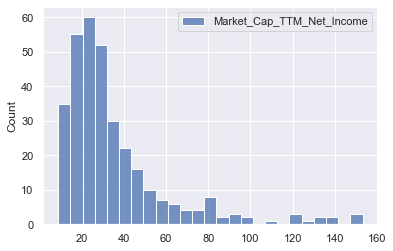

In [341]:
sns.histplot(pe_data_new[['Market_Cap_TTM_Net_Income']])

- Extreme outliers in higher values for PE ratio removed, but still some positive skewness
    > Use log of PE ratios instead of PE ratio, to make data more Gaussian

<AxesSubplot:ylabel='Count'>

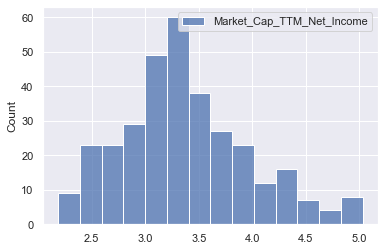

In [342]:
sns.histplot(np.log(pe_data_new[['Market_Cap_TTM_Net_Income']]))

- The log of PE ratios looks more Gaussian, and we will use this for predictions

<AxesSubplot:ylabel='Count'>

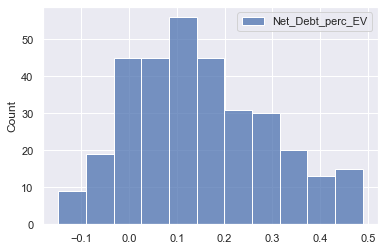

In [343]:
sns.histplot(pe_data_new[['Net_Debt_perc_EV']])

- Extreme outliers in higher values for Net debt as % of EV removed and data shows no extreme skewness anymore

### 2.3 Split into training and testing set

Below code splits our samples into training and testing sets.
We will use a 80% training and 20% testing split.

Note that we also transform our target PE ratios by taking the log.

In [344]:
from sklearn.model_selection import train_test_split

X = pe_data_new[['Sector', 'Net_Income_Forecast_CAGR_10y', 'Avg_Net_Income_Margin_Forecast_10y', 'Beta_5y', 'Net_Debt_perc_EV']]
Y = np.log(pe_data_new[['Market_Cap_TTM_Net_Income']])
Y = Y.rename(columns={'Market_Cap_TTM_Net_Income': 'Log_Market_Cap_TTM_Net_Income'})

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, test_size = 0.3, random_state=5)

In [345]:
X_train.head(5)

,Sector,Net_Income_Forecast_CAGR_10y,Avg_Net_Income_Margin_Forecast_10y,Beta_5y,Net_Debt_perc_EV
Name,,,,,
"AMETEK, Inc.",Industrials,0.052889,0.212410,1.278543,0.072059
Fox Corporation,Communication Services,0.001419,0.073721,0.000000,0.188264
Ralph Lauren Corporation,Consumer Discretionary,0.034982,0.074732,1.206839,0.181728
The Sherwin-Williams Company,Materials,0.106755,0.150060,1.137892,0.158060
"Roper Technologies, Inc.",Industrials,0.110710,0.288177,1.059018,0.081942


In [346]:
Y_train.head(5)

,Log_Market_Cap_TTM_Net_Income
Name,
"AMETEK, Inc.",3.320017
Fox Corporation,2.797414
Ralph Lauren Corporation,3.698240
The Sherwin-Williams Company,3.461179
"Roper Technologies, Inc.",3.326395


In [347]:
train_data = Y_train.merge(X_train, how='outer', left_index=True, right_index=True)
test_data = Y_test.merge(X_test, how='outer', left_index=True, right_index=True)

## 3. Discover and visualize the data to gain insights

### 3.1 Summary Statistics

In [348]:
train_data.describe().round(2)

,Log_Market_Cap_TTM_Net_Income,Net_Income_Forecast_CAGR_10y,Avg_Net_Income_Margin_Forecast_10y,Beta_5y,Net_Debt_perc_EV
count,229.00,229.00,229.00,229.00,229.00
mean,3.39,0.08,0.18,0.94,0.15
std,0.59,0.08,0.10,0.44,0.15
min,2.19,-0.20,-0.01,0.00,-0.15
25%,3.01,0.03,0.10,0.65,0.04
50%,3.32,0.07,0.16,0.96,0.13
75%,3.70,0.11,0.25,1.22,0.25
max,5.03,0.67,0.57,2.31,0.48


- median log PE ratio is 3.32, ranging from 2.19 to 5.03
- median expected annual growth over the next 10 years is 7%, ranging from -20% to +67%
- median expected Net income margin over the next 10 years is 16%, ranging from -1% to +57%
- median Beta is 0.96, ranging from 0 to 2.31
- median Net Debt as a % of EV is 13%, ranging from -15% to +48%

Below we will analyse the training data, and analyse how the individual variables relate to our target PE ratio variable.

### 3.2 Correlation Matrix

<AxesSubplot:>

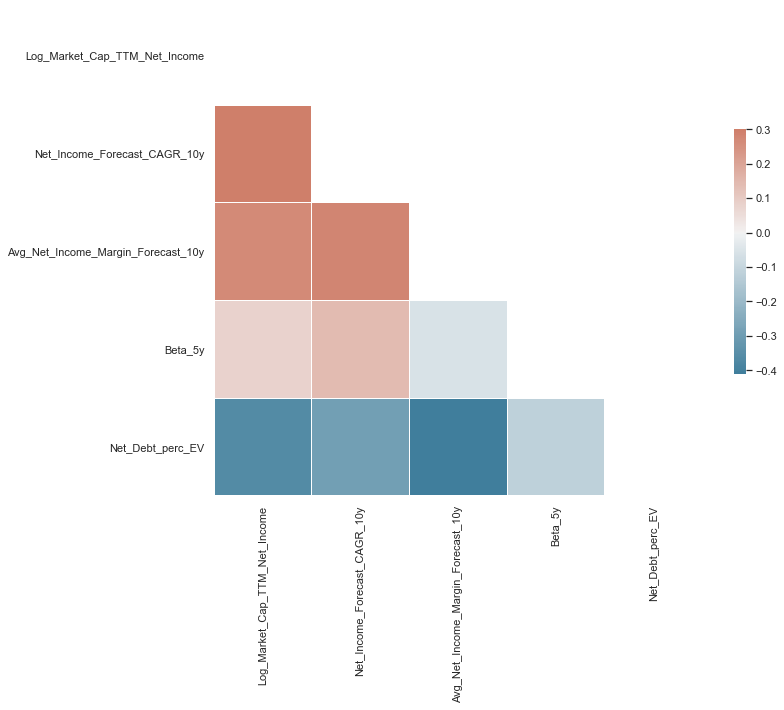

In [349]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = train_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Looking at the first column of the correlation matrix, we can analyse how individual variables are correlated with our target value of the Log of PE ratios
- The growth variable 'Net_Income_Forecast_CAGR_10y' is positively correlated with the PE ratio, as we would expect from financial theory
- The expected margin variable, our proxy for efficient investment and operations is also positively correlated with the PE ratio, as we would expect from financial theory
- Surprisingly the correlation between the Beta in the past 5 years and the PE ratio is very weak and close to 0. Based on financial theory we would have expected a negative correlation, as a higher beta would indicate higher risk
- The variable measuring the amount of debt a company has, 'Net_Debt_perc_EV', is negatively correlated with the PE ratio as we would expect based on financial theory, as companies with higher debt have a higher risk of bankruptcy and also higher expected debt repayments in the future, which reduces future cash flows for investors


In [350]:
train_data.corr().round(2)

,Log_Market_Cap_TTM_Net_Income,Net_Income_Forecast_CAGR_10y,Avg_Net_Income_Margin_Forecast_10y,Beta_5y,Net_Debt_perc_EV
Log_Market_Cap_TTM_Net_Income,1.00,0.43,0.27,0.08,-0.36
Net_Income_Forecast_CAGR_10y,0.43,1.00,0.28,0.14,-0.29
Avg_Net_Income_Margin_Forecast_10y,0.27,0.28,1.00,-0.06,-0.41
Beta_5y,0.08,0.14,-0.06,1.00,-0.12
Net_Debt_perc_EV,-0.36,-0.29,-0.41,-0.12,1.00


### 3.3 Pairplots

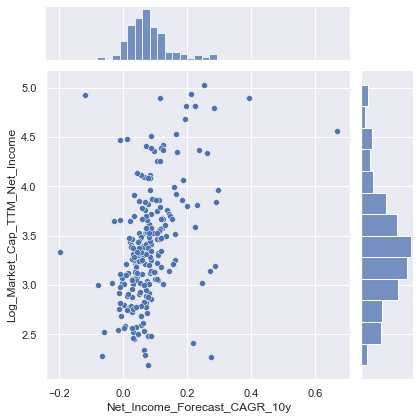

In [351]:
sns.set_theme()
sns.jointplot(data=train_data, x="Net_Income_Forecast_CAGR_10y", y="Log_Market_Cap_TTM_Net_Income")

- Scatterplot indicates positive relationship between expected growth and PE ratios, as indicated by the correlation matrix

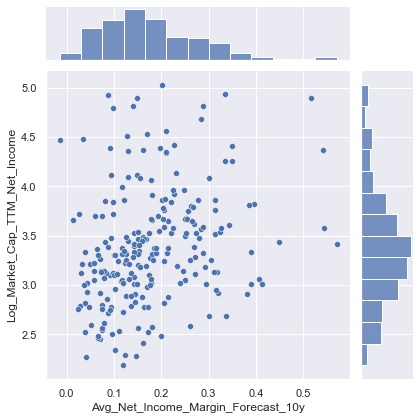

In [352]:
sns.jointplot(data=train_data, x="Avg_Net_Income_Margin_Forecast_10y", y="Log_Market_Cap_TTM_Net_Income")

- Scatterplot indicates positive relationship between expected Net Income margins and PE ratios, as indicated by the correlation matrix

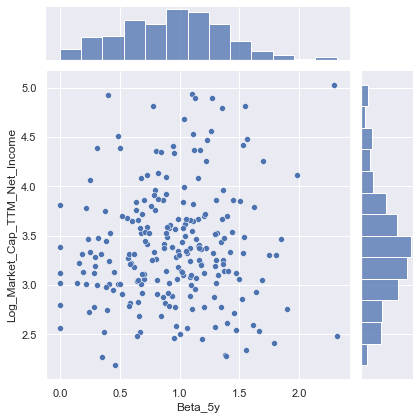

In [353]:
sns.jointplot(data=train_data, x="Beta_5y", y="Log_Market_Cap_TTM_Net_Income")

- Scatterplot does not indicate any strong relationship either way between past 5 year Beta values and PE ratios, as indicated by the correlation matrix

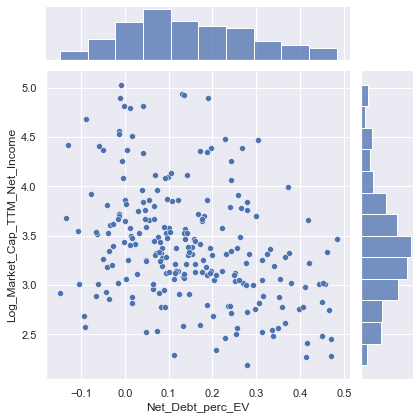

In [354]:
sns.jointplot(data=train_data, x="Net_Debt_perc_EV", y="Log_Market_Cap_TTM_Net_Income")

- Scatterplot indicates negative relationship between Net debt as % of EV and PE ratios, as indicated by the correlation matrix

## 4. Prepare the data for Machine Learning algorithms

Before training our Machine learning algorithms we will do two pre-processing steps.

1. The categorical variable "Sector" will be transformed into a numerical variable with the OneHotEncoder, indicating the sector that applies to each company with 1, and the sectors that don't apply with 0
2. The numerical explanatory variables will be scaled with the StandardScaler to ensure that all new features have mean 0 and standard deviation 1. The scaler is trained on the training set and used to transform both the training and test set

The data will also be split into X and Y variables, Y being the PE ratio which is to be predicted, and X being the features used to predict the PE ratio.

In [293]:
from sklearn.preprocessing import OneHotEncoder

train_data_cat = train_data[['Sector']]
test_data_cat = test_data[['Sector']]

#fit one hot encoder to training set
one_hot = OneHotEncoder(handle_unknown='ignore').fit(train_data_cat)

#transform training set
train_data_cat_one_hot = pd.DataFrame(one_hot.transform(train_data_cat).toarray())
train_data_cat_one_hot.columns = one_hot.get_feature_names(train_data_cat.columns)
train_data_cat_one_hot['Name'] = train_data_cat.index
train_data_cat_one_hot = train_data_cat_one_hot.set_index('Name')

#transform testing set
test_data_cat_one_hot = pd.DataFrame(one_hot.transform(test_data_cat).toarray())
test_data_cat_one_hot.columns = one_hot.get_feature_names(test_data_cat.columns)
test_data_cat_one_hot['Name'] = test_data_cat.index
test_data_cat_one_hot = test_data_cat_one_hot.set_index('Name')

In [294]:
train_data_cat_one_hot.head(5)

,Sector_Communication Services,Sector_Consumer Discretionary,Sector_Consumer Staples,Sector_Energy,Sector_Healthcare,Sector_Industrials,Sector_Information Technology,Sector_Materials,Sector_Real Estate,Sector_Utilities
Name,,,,,,,,,,
"AMETEK, Inc.",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Fox Corporation,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ralph Lauren Corporation,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Sherwin-Williams Company,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"Roper Technologies, Inc.",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [295]:
test_data_cat_one_hot.head(5)

,Sector_Communication Services,Sector_Consumer Discretionary,Sector_Consumer Staples,Sector_Energy,Sector_Healthcare,Sector_Industrials,Sector_Information Technology,Sector_Materials,Sector_Real Estate,Sector_Utilities
Name,,,,,,,,,,
Eastman Chemical Company,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Allegion plc,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Hormel Foods Corporation,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Extra Space Storage Inc.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Target Corporation,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [296]:
from sklearn.preprocessing import StandardScaler

train_data_num = train_data[['Net_Income_Forecast_CAGR_10y','Avg_Net_Income_Margin_Forecast_10y','Beta_5y', 'Net_Debt_perc_EV']]
test_data_num = test_data[['Net_Income_Forecast_CAGR_10y','Avg_Net_Income_Margin_Forecast_10y','Beta_5y', 'Net_Debt_perc_EV']]

#fit standard scaler to training set
scaler = StandardScaler().fit(train_data_num)

#transform training set
train_data_num_scaled = pd.DataFrame(scaler.transform(train_data_num), columns = train_data_num.columns)
train_data_num_scaled['Name'] = train_data.index
train_data_num_scaled = train_data_num_scaled.set_index('Name')

#transform testing set
test_data_num_scaled = pd.DataFrame(scaler.transform(test_data_num), columns = test_data_num.columns)
test_data_num_scaled['Name'] = test_data.index
test_data_num_scaled = test_data_num_scaled.set_index('Name')

In [297]:
train_data_num_scaled.head(5)

,Net_Income_Forecast_CAGR_10y,Avg_Net_Income_Margin_Forecast_10y,Beta_5y,Net_Debt_perc_EV
Name,,,,
"AMETEK, Inc.",-0.343975,0.322551,0.769134,-0.517736
Fox Corporation,-0.967412,-1.005990,-2.133483,0.282818
Ralph Lauren Corporation,-0.560871,-0.996304,0.606348,0.237788
The Sherwin-Williams Company,0.308487,-0.274720,0.449821,0.074738
"Roper Technologies, Inc.",0.356389,1.048336,0.270757,-0.449652


In [298]:
train_data_num_scaled.describe().round(2)

,Net_Income_Forecast_CAGR_10y,Avg_Net_Income_Margin_Forecast_10y,Beta_5y,Net_Debt_perc_EV
count,229.00,229.00,229.00,229.00
mean,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-3.38,-1.85,-2.13,-2.03
25%,-0.56,-0.76,-0.66,-0.73
50%,-0.13,-0.18,0.05,-0.10
75%,0.32,0.65,0.63,0.72
max,7.10,3.75,3.11,2.32


In [299]:
X_train = train_data_num_scaled.merge(train_data_cat_one_hot, how='outer', left_index=True, right_index=True)
X_train.head(5)

,Net_Income_Forecast_CAGR_10y,Avg_Net_Income_Margin_Forecast_10y,Beta_5y,Net_Debt_perc_EV,Sector_Communication Services,Sector_Consumer Discretionary,Sector_Consumer Staples,Sector_Energy,Sector_Healthcare,Sector_Industrials,Sector_Information Technology,Sector_Materials,Sector_Real Estate,Sector_Utilities
Name,,,,,,,,,,,,,,
"AMETEK, Inc.",-0.343975,0.322551,0.769134,-0.517736,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Fox Corporation,-0.967412,-1.005990,-2.133483,0.282818,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ralph Lauren Corporation,-0.560871,-0.996304,0.606348,0.237788,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Sherwin-Williams Company,0.308487,-0.274720,0.449821,0.074738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"Roper Technologies, Inc.",0.356389,1.048336,0.270757,-0.449652,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [300]:
Y_train = train_data[['Log_Market_Cap_TTM_Net_Income']]
Y_train.head(5)

,Log_Market_Cap_TTM_Net_Income
Name,
"AMETEK, Inc.",3.320017
Fox Corporation,2.797414
Ralph Lauren Corporation,3.698240
The Sherwin-Williams Company,3.461179
"Roper Technologies, Inc.",3.326395


In [301]:
X_test = test_data_num_scaled.merge(test_data_cat_one_hot, how='outer', left_index=True, right_index=True)
X_test.head(5)

,Net_Income_Forecast_CAGR_10y,Avg_Net_Income_Margin_Forecast_10y,Beta_5y,Net_Debt_perc_EV,Sector_Communication Services,Sector_Consumer Discretionary,Sector_Consumer Staples,Sector_Energy,Sector_Healthcare,Sector_Industrials,Sector_Information Technology,Sector_Materials,Sector_Real Estate,Sector_Utilities
Name,,,,,,,,,,,,,,
Eastman Chemical Company,2.163536,-0.066516,1.378961,1.212203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Allegion plc,-0.299303,-0.073863,0.428535,-0.234235,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Hormel Foods Corporation,-0.557665,-0.728099,-2.168545,-1.114877,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Extra Space Storage Inc.,-0.840145,1.915674,-1.576251,0.767138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Target Corporation,-0.384196,-1.276158,-0.202580,-0.285802,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [302]:
Y_test = test_data[['Log_Market_Cap_TTM_Net_Income']]
Y_test.head(5)

,Log_Market_Cap_TTM_Net_Income
Name,
Eastman Chemical Company,3.005154
Allegion plc,3.491612
Hormel Foods Corporation,3.355020
Extra Space Storage Inc.,3.559280
Target Corporation,3.121729


### 5. Select, train and fine-tune models
Now it's finally time to train our machine learning models.
As this is a regression task, we will take into considering below models.
1. Ridge Regression (Regularize linear regression)
2. KNeighborsRegressor
3. SVR linear
4. SVR rbf
5. RandomForestRegressor
6. Ensemble of models 1-5

- To optimize the hyper parameters, we will use grid search with fivefold cross validation. 
- The metric we will use to evaluate/score the performance is the r-squared of the model. The r-squared is the proportion of the variance of the target variable log PE ratio explained by our model.

In [303]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge(max_iter = 100000)
grid_values = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 200, 300, 400, 500]}

# default metric to optimize over grid parameters: accuracy
grid_ridge = GridSearchCV(ridge, param_grid = grid_values, cv=5, scoring = 'r2')
grid_ridge.fit(X_train, Y_train.values.ravel());

print('Grid best parameter: ', grid_ridge.best_params_)
print('Grid best score: ', grid_ridge.best_score_.round(3))

Grid best parameter:  {'alpha': 10}
Grid best score:  0.221


In [304]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
grid_values = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]}

# default metric to optimize over grid parameters: accuracy
grid_knn = GridSearchCV(knn, param_grid = grid_values, cv=5, scoring = 'r2')
grid_knn.fit(X_train, Y_train.values.ravel());

print('Grid best parameter: ', grid_knn.best_params_)
print('Grid best score: ', grid_knn.best_score_.round(3))

Grid best parameter:  {'n_neighbors': 7}
Grid best score:  0.234


In [305]:
from sklearn.svm import SVR

svr1 = SVR(kernel='linear')
grid_values = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 200, 300, 400, 500]}

# default metric to optimize over grid parameters: accuracy
grid_svr1 = GridSearchCV(svr1, param_grid = grid_values, cv=5, scoring = 'r2')
grid_svr1.fit(X_train, Y_train.values.ravel());

print('Grid best parameter: ', grid_svr1.best_params_)
print('Grid best score: ', grid_svr1.best_score_.round(3))

Grid best parameter:  {'C': 400}
Grid best score:  0.202


In [306]:
from sklearn.svm import SVR

svr2 = SVR(kernel='rbf')
grid_values = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 200, 300, 400, 500]}

# default metric to optimize over grid parameters: accuracy
grid_svr2 = GridSearchCV(svr2, param_grid = grid_values, cv=5, scoring = 'r2')
grid_svr2.fit(X_train, Y_train.values.ravel());

print('Grid best parameter: ', grid_svr2.best_params_)
print('Grid best score: ', grid_svr2.best_score_.round(3))

Grid best parameter:  {'C': 1}
Grid best score:  0.246


In [307]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
grid_values = {'max_depth': [2, 3, 4, 5, 6, 7, 8], 
               'n_estimators': [50, 75, 100, 125, 150]}

# default metric to optimize over grid parameters: accuracy
grid_rf = GridSearchCV(rf, param_grid = grid_values, cv=5, scoring = 'r2')
grid_rf.fit(X_train, Y_train.values.ravel())

print('Grid best parameter: ', grid_rf.best_params_)
print('Grid best score: ', grid_rf.best_score_.round(3))

Grid best parameter:  {'max_depth': 8, 'n_estimators': 100}
Grid best score:  0.27


In [308]:
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_val_score

er = VotingRegressor([('lr_ridge', grid_ridge), ('knn', grid_knn), ('svr_linear', grid_svr1), 
                                     ('svr_rbf', grid_svr2), ('rf', grid_rf)])
er.fit(X_train, Y_train.values.ravel())
cv_score = cross_val_score(er, X_train, Y_train.values.ravel(), cv=3, scoring = 'r2').mean().round(3)
print('CV score', cv_score)

CV score 0.284


### 6. Conclusion

Based on the average cross validation r-squared from five-fold cross validation, we get the below r-squared for each model.

In [309]:
classifiers = ['Ridge', 
               'KNeighborsRegressor',
               'SVR linear',
               'SVR rbf', 
               'RandomForestClassifier', 
               'VotingClassifier']

scores = [grid_ridge.best_score_.round(3), 
          grid_knn.best_score_.round(3), 
          grid_svr1.best_score_.round(3), 
          grid_svr2.best_score_.round(3), 
          grid_rf.best_score_.round(3), 
          cv_score.round(3)]

model_scores = pd.DataFrame(data= scores, columns = ['CV_Accuracy'], index = classifiers)
model_scores

,CV_Accuracy
Ridge,0.221
KNeighborsRegressor,0.234
SVR linear,0.202
SVR rbf,0.246
RandomForestClassifier,0.270
VotingClassifier,0.284


The model with the highest cross validation r-squared score is the ensemble model with an r-squared of 28.4%. We will use this model to predict the out of sample error on the test data.

In [310]:
er.score(X_test, Y_test).round(3)

0.221

Both our cross validation r-squared values in predicting the log of the PE ratios, as well as the out of sample r-squared estimation on the test set indicate that our fundamental financial explanatory variables relating to expected growth, expected margins, beta and the level of debt a company has explains only 22% of the variance in the PE ratios.

This illustrates that financial data is noisy, and 78% of the variance in the PE ratios remains unexplained with our variables.